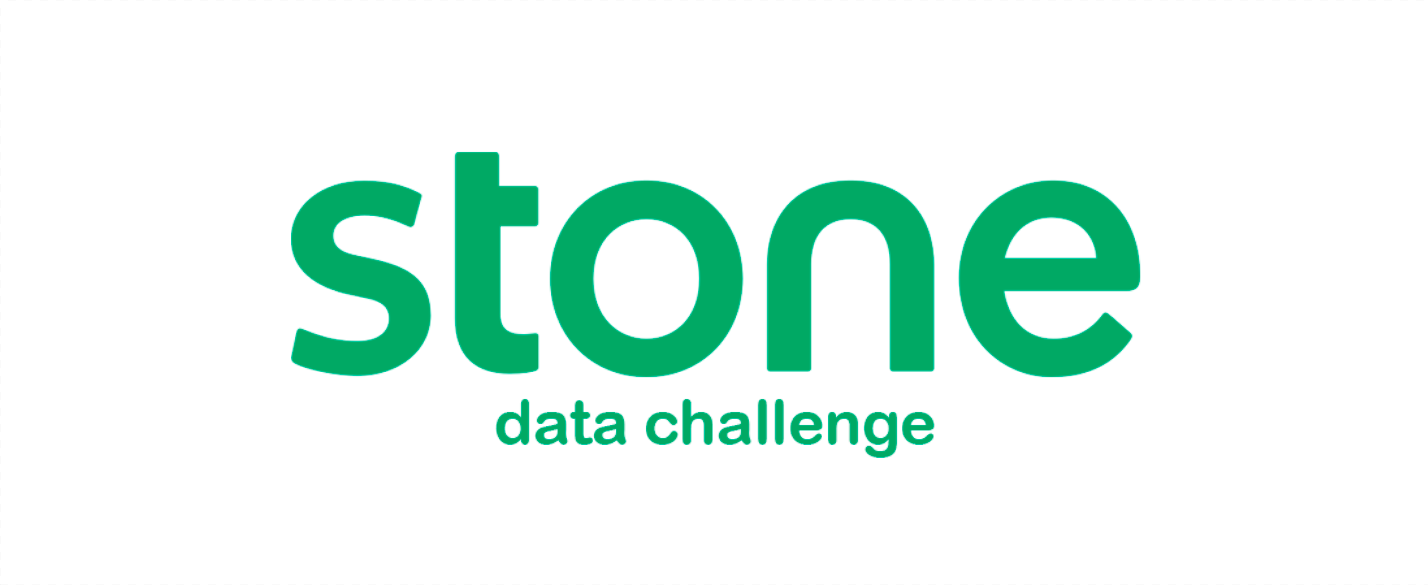

#### **Objetivo do Modelo**:
* Para cada um dos mais de 200 mil clientes, estimar o TPV mensal de Agosto à Dezembro de 2020. A métrica a ser utilizada na avaliação é o erro absoluto relativo. 


#### **Metodologia**:
* **Preparação dos Dados**:
    * Parsing e decomposição das datas
    * Feature Engineering (label encoding, agrupamento, redução de categorias e muitos outros - mais detalhes no script `preprocessing.py`)
    * Imputação de valores utilizando FFill.
    * Padronização da variável Estado
    * Criação de Lags e Diffs do TPV-Mensal


* **Baselines**
    * Média dos últimos meses (com vazamento de dados)
    * Média dos últimos meses (sem vazamento de dados)
    * TPV do último mes (só se aplica para validação)
    
    
* **Definição do Modelo**
    * Devido ao alto número de features categóricas e categorias, decidi por modelos ensemble.
    * Foram treinados modelos em 3 algoritmos diferentes - RandomForest, CatBoost e LightGBM
        * RandomForest foi escolhido por ser um bom baseline com hiperparâmetros padrão.
        * Além da ótima perfomance padrão, o CatBoost foi escolhido por funcionar muito bem com dados categóricos.
        * LightGBM lida muito bem com categóricos label encoded e permite maior controle dos hiperparâmetros, permitindo alcançar métricas melhores.
    * RandomForest foi descartado por não ser eficiente com esse volume de dados.
    
    
* **Hiperparametrização**:
    * Utilizei o Optuna (integrado ao LightGBM e API padrão).


* **Modelo Final**
    * CatBoost.


* **Métricas de Avaliação**
    * MAE e MSE - Mean Absolut/Squared Error. Se aproxima muito da métrica utilizada no desafio e a segunda força a redução do erro em empresas de porte maior, que terão maior peso na média.
    * Idealmente, eu acredito que para esse problema o uso do RMLSE poderia ser interessante também (considerando o range que o TPV-Value pode alcançar)


* **Validação**
    * O dataset foi separado em set de treino e teste de forma aleatória.
    * Os modelos foram treinados no set de treino**, utilizando validação sliding window entre os meses de Março e Julho.
        * **A única exceção foi o RandomForest, devido à ineficiência nesse volume de dados.
    * Em seguida, os modelos foram aplicados no set de teste para verificar a capacidade de generalização.
    
    
* **Dataset Resultante**:
    * `previsoes_ago_dez.csv`

### Iniando o Notebook

In [1]:
# Import libs

# Wrangling e Analysis
import pandas as pd
import numpy as np

# Dataviz
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestRegressor
import catboost as cb
import optuna

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

pd.options.display.float_format = '{:,.2f}'.format

**OBS.:** O LightGBM não oferece suporte para suprimir alguns warnings e como estou utilizando um loop para realizar o sliding window, as células que treinam o modelo acabam tendo um output bem poluído. O filtro abaixo só foi implementado após o término do treinamento para que o notebook ficasse mais limpo.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import nos datasets
df = pd.read_csv('data/df_modelo.csv', parse_dates = ['mes_referencia'])
df.drop("Unnamed: 0", axis = 1, inplace = True)

In [4]:
df = df.sort_values(['mes_referencia', 'id'])
df

id mes_referencia  TPV_mensal  Mês  Trimestre   Ano  \
466          29     2017-07-31   52,103.00    7          3  2017   
503          30     2017-07-31    2,549.80    7          3  2017   
1366         86     2017-07-31   10,010.96    7          3  2017   
1934        126     2017-07-31    9,935.00    7          3  2017   
2277        150     2017-07-31    9,453.05    7          3  2017   
...         ...            ...         ...  ...        ...   ...   
3066739  206326     2020-07-31   10,984.30    7          3  2020   
3066746  206327     2020-07-31   50,545.80    7          3  2020   
3066759  206328     2020-07-31    4,680.00    7          3  2020   
3066767  206329     2020-07-31   60,213.99    7          3  2020   
3066771  206330     2020-07-31   16,389.47    7          3  2020   

         tpv_ultimo_mes  diff_ultimo_mes  tpv_ultimo-1_mes  diff_ultimo-1_mes  \
466                 nan              nan               nan                nan   
503                 nan              nan               nan                nan   
1366                nan              nan               nan                nan   
1934                nan              nan               nan                nan   
2277                nan              nan               nan                nan   
...                 ...              ...               ...                ...   
3066739          570.00          -405.00            570.00            -405.00   
3066746       49,672.30        31,805.90         49,672.30          31,805.90   
3066759        3,810.00           -90.00          3,810.00             -90.00   
3066767       61,699.27         5,998.70         61,699.27           5,998.70   
3066771       15,098.04        -3,237.58         15,098.04          -3,237.58   

         ...  is_missing_sub_segmento  persona  porte  tipo_documento  Estado  \
466      ...                        0       11      6               2       6   
503      ...                        0        8      3               2      10   
1366     ...                        0       11      5               2      19   
1934     ...                        0        6      4               2      26   
2277     ...                        0        7      3               2      10   
...      ...                      ...      ...    ...             ...     ...   
3066739  ...                        0        7      4               1      26   
3066746  ...                        0        7      4               2      16   
3066759  ...                        0        2      2               1      19   
3066767  ...                        0       11      6               2      10   
3066771  ...                        0        8      4               1       2   

         is_missing_Estado  tem_duplicados  StoneCreatedDate  \
466                      0               1                36   
503                      0               1                37   
1366                     0               0                64   
1934                     0               1                35   
2277                     0               1                 9   
...                    ...             ...               ...   
3066739                  0               0                87   
3066746                  0               0                95   
3066759                  0               0                89   
3066767                  0               0                94   
3066771                  0               0                98   

         diff_FirstTransaction_Created  Região  
466                               0.82       0  
503                               2.18       4  
1366                              1.26       4  
1934                              2.20       4  
2277                              2.60       4  
...                                ...     ...  
3066739                           1.26       4  
3066746                           0.39       2  
3066759                           0.82  

In [5]:
# Separando sets - train e test set
all_ids = np.array(df.id.unique())

np.random.seed(42)
test_ids = np.random.choice(all_ids, size = round(0.15*len(all_ids)))

df_test = df[df.id.isin(test_ids)]
df_train = df[~df.id.isin(test_ids)]

Uma vez separados os sets de treino e de teste e confirmado que está tudo correto, podemos calcular o score baseline. Irei utilizar os últimos meses do dataset (Mar/2020 - Jul/2020) para testar o funcionamento dos modelos. Após a previsão do primeiro mês, o modelo incorporará o mês previsto para prever o próximo (sliding window). 

### Baselines

Irei utilizar 3 baselines para comparar os resultados.

* Erro comparando a venda atual com a venda do último mês.
    * Esse é um score baseline considerado relativamente forte para séries temporais, principalmente quando atribuídas à vendas ou saídas de produto.
* Erro comparando a venda atual com a média das vendas até o mês atual.
    * Definido de acordo com o PDF do case.
* Erro comparando a venda atual com a média das vendas incluindo o mês atual e seguintes, se aplicável.
    * Também definido de acordo com o PDF do case, nesse caso ocorre vazamento de dados o que aumenta o score.

In [6]:
# Definindo Baselines - Venda do Ultimo Mes

mean_sq_error = []
mean_error = []

for mes in range(3,8):
    val = df_train[(df_train['Ano'] == 2020) & (df_train['Mês'] == mes)]

    val = val.fillna(0)
    pred = val['tpv_ultimo_mes'].values

    sqr_error = mean_squared_error(val['TPV_mensal'].values, pred)
    error = mean_absolute_error(val['TPV_mensal'].values, pred)
    
    print('Mês %d - Erro Quadrado %.5f      - Erro Absoluto %.5f' % (mes, sqr_error, error))
    mean_sq_error.append(sqr_error)
    mean_error.append(error)
    
print('Média Erro Quadrado = %.5f      - Média Erro Absoluto %.5f' % (np.mean(mean_sq_error), np.mean(mean_error)))

Mês 3 - Erro Quadrado 681729315.08537      - Erro Absoluto 7490.14150
Mês 4 - Erro Quadrado 358095605.61061      - Erro Absoluto 7544.06240
Mês 5 - Erro Quadrado 211326978.59817      - Erro Absoluto 6555.97363
Mês 6 - Erro Quadrado 197834376.84456      - Erro Absoluto 5691.07836
Mês 7 - Erro Quadrado 177010566.96613      - Erro Absoluto 6123.64362
Média Erro Quadrado = 325199368.62097      - Média Erro Absoluto 6680.97990


In [7]:
# Definindo Baselines - #2 Média dos últimos meses (nao conta em frente)

mean_sq_error = []
mean_error = []

for mes in range(3,8):     
    val = df_train[(df_train['Ano'] == 2020) & (df_train['Mês'] == mes)]
    ids = val['id'].unique()
    
    pred = df_train[(df_train['id'].isin(ids)) & (df_train['mes_referencia'] < np.datetime64(f'2020-0{mes + 1}'))]\
                                                                            .groupby('id')['TPV_mensal']\
                                                                            .mean()

    sqr_error = mean_squared_error(val['TPV_mensal'].values, pred)
    error = mean_absolute_error(val['TPV_mensal'].values, pred)
    
    print('Mês %d - Erro Quadrado %.5f      - Erro Absoluto %.5f' % (mes, sqr_error, error))
    mean_sq_error.append(sqr_error)
    mean_error.append(error)
    
print('Média Erro Quadrado = %.5f      - Média Erro Absoluto %.5f' % (np.mean(mean_sq_error), np.mean(mean_error)))

Mês 3 - Erro Quadrado 560238473.03814      - Erro Absoluto 6942.39260
Mês 4 - Erro Quadrado 881247364.23930      - Erro Absoluto 9223.32410
Mês 5 - Erro Quadrado 803561623.70998      - Erro Absoluto 8936.66330
Mês 6 - Erro Quadrado 702691328.81375      - Erro Absoluto 8427.84512
Mês 7 - Erro Quadrado 699526725.67094      - Erro Absoluto 9413.33451
Média Erro Quadrado = 729453103.09442      - Média Erro Absoluto 8588.71193


In [8]:
# Definindo Baselines - #3 Média de todos os últimos meses

mean_error = []
mean_sq_error = []

for mes in range(3,8):     
    val = df_train[(df_train['Ano'] == 2020) & (df_train['Mês'] == mes)]
    ids = val['id'].unique()
    
    pred = df_train[(df_train['id'].isin(ids))].groupby('id')['TPV_mensal'].mean()

    sqr_error = mean_squared_error(val['TPV_mensal'].values, pred)
    error = mean_absolute_error(val['TPV_mensal'].values, pred)
    
    print('Mês %d - Erro Quadrado %.5f      - Erro Absoluto %.5f' % (mes, sqr_error, error))
    mean_sq_error.append(sqr_error)
    mean_error.append(error)
    
print('Média Erro Quadrado = %.5f      - Média Erro Absoluto %.5f' % (np.mean(mean_sq_error), np.mean(mean_error)))

Mês 3 - Erro Quadrado 427551797.36149      - Erro Absoluto 6589.17186
Mês 4 - Erro Quadrado 730432233.90851      - Erro Absoluto 8705.23750
Mês 5 - Erro Quadrado 699455484.97461      - Erro Absoluto 8215.67843
Mês 6 - Erro Quadrado 645478279.49912      - Erro Absoluto 7805.07531
Mês 7 - Erro Quadrado 699526725.67094      - Erro Absoluto 9413.33451
Média Erro Quadrado = 640488904.28294      - Média Erro Absoluto 8145.69952


Como esperado, a ordem dos scores abs entre as baselines:
1. Erro da Venda do Último Mês: **6680.97**
2. Erro da Média de Todos os Meses: **8145.69**
3. Erro da Média dos últimos meses (nao conta em frente): **8588.71**

### RF Default e HiperParametrização do LightGBM e do CatBoost

**Obs.:** Os hiperparâmetros obtidos aqui não são necessariamente os melhores possíveis. Talvez seja possível aumentar a precisão mas devido ao limite para a entrega, reduzi o tempo de busca.

In [9]:
#### Random Forest

# Hiperparametros padrao
# RF foi extremamente ineficiente no set de treino e decidi treina-lo apenas no set de test.

mean_error = []
mean_sq_error = []

for mes in range(3,8):
    
    
    # Treinar com todos os meses até o 'mes' não incluso
    train = df_test[df_test['mes_referencia'] < np.datetime64(f'2020-0{mes}')]
    
    # Prever o 'mes'
    val = df_test[(df_test['Ano'] == 2020) & (df_test['Mês'] == mes)]
    
    
    # RF não lida c/ valores NaN por padrão
    val = val.fillna(0)
    train = train.fillna(0)
    
    # Train test split
    X_train = train.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
    
    X_test = val.drop(['id','TPV_mensal', 'mes_referencia'], axis=1)
    
    y_train, y_test = train['TPV_mensal'].values, val['TPV_mensal'].values

    # Instancia e Fita o Modelo
    model = RandomForestRegressor(n_estimators=100, n_jobs=8, random_state=0)
    model.fit(X_train, y_train)
    
    # Resultados Métricas
    pred = model.predict(X_test)
    sqr_error = mean_squared_error(y_test, pred)
    error = mean_absolute_error(y_test, pred)
    
    print('Mês %d - Erro Quadrado %.5f      - Erro Absoluto %.5f' % (mes, sqr_error, error))
    
    mean_sq_error.append(sqr_error)
    mean_error.append(error)
    
print('Média Erro Quadrado = %.5f      - Média Erro Absoluto %.5f' % \
      (np.mean(mean_sq_error), np.mean(mean_error)))

Mês 3 - Erro Quadrado 1066535979.42620      - Erro Absoluto 7711.43782
Mês 4 - Erro Quadrado 1507910399.64810      - Erro Absoluto 8202.73017
Mês 5 - Erro Quadrado 212121211.67307      - Erro Absoluto 6611.49394
Mês 6 - Erro Quadrado 187975563.15185      - Erro Absoluto 5644.76517
Mês 7 - Erro Quadrado 141532783.40912      - Erro Absoluto 5908.00208
Média Erro Quadrado = 623215187.46167      - Média Erro Absoluto 6815.68584


Os resultados do utilizando o RandomForest foram medianos, melhores que os baselines a partir da média e mas inferiores que o baseline mais forte (venda do último mês). Além disso, o algoritmo demora muito para treinar. 

A hiperparametrização do LightGBM com o Optuna integrado é mais rápido e normalmente retorna resultados melhores de acordo com a documentação. No entanto, como por estar sendo realizado dentro de um loop, a célula vai retornar 5 conjuntos de melhor hiperparâmetros. 

Isso não acontece no CatBoost, uma vez que é possível definir como métrica a ser minimizada a média do erro das 5 semanas. 

In [10]:
#### LightGBM
import lightgbm as lgb

# HyperOPT c/ Optuna 

def lightgbm_objective(trial):
    
    mean_error = []
    mean_sq_error = []

    for mes in range(3,8):

        # Treinar com todos os meses até o 'mes' não incluso
        train = df_train[df_train['mes_referencia'] < np.datetime64(f'2020-0{mes}')]

        # Prever o 'mes'
        val = df_train[(df_train['Ano'] == 2020) & (df_train['Mês'] == mes)]

        X_train = train.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
        X_test = val.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)

        y_train, y_test = train['TPV_mensal'].values, val['TPV_mensal'].values

        # Separa features categóricas -> LGBM lida bem com NaNs e com elas
        train_data = lgb.Dataset(X_train,
                                 label=y_train,
                                 categorical_feature = ['MCC', 'MacroClassificacao',
                                                        'sub_segmento', 'persona', 'porte',
                                                        'tipo_documento', 'Estado', 'StoneCreatedDate',
                                                        'Região'])
        test_data = lgb.Dataset(X_test,
                                label=y_test,
                                reference=train_data)

        # Hiperparametros Fixos
    
        params = {'objective': 'regression',
                  'metric': 'rmse',
                  'verbosity': -1,
                  'boosting_type': 'gbdt',
                  'force_row_wise': True,
                  'max_depth': -1,
                  'random_seed': 0,
                  'num_boost_round': 2000,
                  'reg_sqrt': True,

                  'max_bin': trial.suggest_int('max_bin', 1, 512),
                  'num_leaves': trial.suggest_int('num_leaves', 2, 512),

                  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
                  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),

                  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
                  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
                  'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),

                  'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50)
                   }
    
    
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    
        optuna.logging.set_verbosity(optuna.logging.FATAL)

        # Instancia e Treina o Modelo
        # Os parametros do log da hiperparametrização foram reduzidos p/ evitar a poluição do notebook entregue
        # p/ debugging, remover o show_progress_bar e o verbose_eval
        model_lgbm = lgb.train(params, train_data,                     
                               valid_sets = [train_data, test_data],
                               valid_names=['valid'],
                               verbose_eval = 0,
                               early_stopping_rounds=100,
                               )
        # Resultados Métricas
        pred = model_lgbm.predict(X_test)
        sqr_error = mean_squared_error(y_test, pred)
        error = mean_absolute_error(y_test, pred)


        mean_sq_error.append(sqr_error)
        mean_error.append(error)
        
    return np.mean(mean_error)

                               
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize",
)

study.optimize(lightgbm_objective, n_trials=100,
               show_progress_bar = False)

print(f"Number of finished trials: {len(study.trials)}")

print("Best trial:")
trial = study.best_trial

print(f"Média Erro Absoluto: {trial.value}")

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-09 19:25:34,694] A new study created in memory with name: no-name-704fdc1d-b504-4fc5-abb2-dd02483d9859


Number of finished trials: 100
Best trial:
Média Erro Absoluto: 6515.758483569206
  Params: 
    max_bin: 471
    num_leaves: 171
    lambda_l1: 0.0003205689153580989
    lambda_l2: 8.812493052256857e-05
    feature_fraction: 0.45811376398887355
    bagging_fraction: 0.6370243208208551
    bagging_freq: 7
    min_data_in_leaf: 47


In [11]:
#### LightGBM

# HyperOPT c/ Optuna
import optuna.integration.lightgbm as lgb

mean_error = []
lgbm_param_list = []
mean_sq_error = []

for mes in range(3,8):
    
    # Treinar com todos os meses até o 'mes' não incluso
    train = df_train[df_train['mes_referencia'] < np.datetime64(f'2020-0{mes}')]
    
    # Prever o 'mes'
    val = df_train[(df_train['Ano'] == 2020) & (df_train['Mês'] == mes)]
    
    X_train = train.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
    X_test = val.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
        
    y_train, y_test = train['TPV_mensal'].values, val['TPV_mensal'].values
    
    # Separa features categóricas -> LGBM lida bem com NaNs e com elas
    train_data = lgb.Dataset(X_train,
                             label=y_train,
                             categorical_feature = ['MCC', 'MacroClassificacao',
                                                    'sub_segmento', 'persona', 'porte',
                                                    'tipo_documento', 'Estado', 'StoneCreatedDate',
                                                    'Região'])
    
    test_data = lgb.Dataset(X_test,
                            label=y_test,
                            reference=train_data)
    
    # Hiperparametros Fixos
    params = {'objective': 'regression',
              'metric': 'root_mean_squared_error',
              'boosting':'gbdt',
              'verbosity': 0,
              'random_seed': 0,
              'force_row_wise': True}
    
    # Reduz o nível do log do optuna -> Comentar essa linha p/ debugging
    optuna.logging.set_verbosity(optuna.logging.FATAL)
    
    # Instancia e Treina o Modelo
    # Os parametros do log da hiperparametrização foram reduzidos p/ evitar a poluição do notebook entregue
    # p/ debugging, remover o show_progress_bar e o verbose_eval
    model_lgbm = lgb.train(params, train_data,                     
                           valid_sets = [train_data, test_data],
                           valid_names=['valid'],
                           verbose_eval = 0,
                           early_stopping_rounds=100,
                           time_budget = 600,
                           show_progress_bar = False,
                           )
    # Resultados optuna
    best_params = model_lgbm.params 
    lgbm_param_list.append(best_params)
    print(f'\nBest params: {best_params}')
    
    # Resultados Métricas
    pred = model_lgbm.predict(X_test)
    sqr_error = mean_squared_error(y_test, pred)
    error = mean_absolute_error(y_test, pred)
    
    print('\nMês %d - Erro Quadrado %.5f      - Erro Absoluto %.5f\n==============' % (mes, sqr_error, error))
    
    mean_sq_error.append(sqr_error)
    mean_error.append(error)
    
print('==============\nMédia Erro Quadrado = %.5f      -Média Erro Absoluto %.5f' % \
      (np.mean(mean_sq_error), np.mean(mean_error)))


Best params: {'objective': 'regression', 'metric': 'rmse', 'boosting': 'gbdt', 'verbosity': 0, 'random_seed': 0, 'force_row_wise': True, 'feature_pre_filter': False, 'lambda_l1': 1.5239450976956164e-08, 'lambda_l2': 1.0672362473956671e-08, 'num_leaves': 128, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100, 'categorical_column': [25, 26, 30, 32, 33, 34, 35, 38, 40]}

Mês 3 - Erro Quadrado 300974027.46417      - Erro Absoluto 8501.06028

Best params: {'objective': 'regression', 'metric': 'rmse', 'boosting': 'gbdt', 'verbosity': 0, 'random_seed': 0, 'force_row_wise': True, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 35, 'feature_fraction': 0.9799999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100, 'categorical_column': [25, 26, 30, 32, 33, 34, 35, 38, 40]}

Mês 4 - Erro Quadr

In [12]:
#### CatBOOST

# HyperOPT c/ Optuna 

def catboost_objective(trial):
    
    mean_error = []
    mean_sq_error = []
        
    for mes in range(3,8):
            
        # Treinar com todos os meses até o 'mes' não incluso
        train = df_train[df_train['mes_referencia'] < np.datetime64(f'2020-0{mes}')]
            
        # Prever o 'mes'
        val = df_train[(df_train['Ano'] == 2020) & (df_train['Mês'] == mes)]

        X_train = train.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
        X_test = val.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
                
        y_train, y_test = train['TPV_mensal'].values, val['TPV_mensal'].values
            
        # Setup dos hyperparametros
        params = {'objective': trial.suggest_categorical('objective', ['RMSE', 'MAE']),
                 'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 0.1),
                 'depth': trial.suggest_int('depth', 1, 12),
                 'boosting_type': trial.suggest_categorical(
                     'boosting_type', ['Ordered', 'Plain']),

                 "bootstrap_type": trial.suggest_categorical(
                     "bootstrap_type", ["Bayesian", "Bernoulli"]
                 ),
                 "used_ram_limit": "12gb"}

        if params["bootstrap_type"] == "Bayesian":
            params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)

        elif params["bootstrap_type"] == "Bernoulli":
            params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

        # Instancia o modelo (log = silent / para debug, remover o parametro)
        model_cb = cb.CatBoostRegressor(logging_level='Silent',
                                        random_state = 0,
                                        **params)

        model_cb.fit(X_train, y_train,
                     eval_set=[(X_test, y_test)],
                     verbose=0,
                     cat_features = ['MCC', 'MacroClassificacao',
                                     'sub_segmento', 'persona', 'porte',
                                     'tipo_documento', 'Estado', 'StoneCreatedDate',
                                     'Região'],
                     early_stopping_rounds=100)


        # Resultados Métricas
        pred = model_cb.predict(X_test)
            
        sqr_error = mean_squared_error(y_test, pred)
        error = mean_absolute_error(y_test, pred)
            
        mean_sq_error.append(sqr_error)
        mean_error.append(error)

    return np.mean(mean_error)

# Reduz o nível do log do optuna -> Comentar essa linha p/ debugging
optuna.logging.set_verbosity(optuna.logging.FATAL)

# Intancia a hiperparametrização
study = optuna.create_study(direction="minimize")

study.optimize(catboost_objective, n_trials=100,
               show_progress_bar = False)


KeyboardInterrupt: 

Infelizmente, o tempo que eu tinha para a otimização dos hiperparâmetros se excedeu e tive que para-la manualmente. Com isso, os resultados parciais do estudo do optuna foram: 

In [17]:
# Resultados do optuna - CatBoost

print(f"Best trial:")

trial = study.best_trial

print(f"Value: {trial.value}")

print(" Params: ")

for key, value in trial.params.items():
    print(f"{key}: {value}")

Best trial:
Value: 6413.358994018839
 Params: 
objective: MAE
colsample_bylevel: 0.09195418306561731
depth: 12
boosting_type: Plain
bootstrap_type: Bernoulli
subsample: 0.5642513852331853


In [19]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  8,851.14 2021-04-09 22:42:50.227967 2021-04-09 22:48:28.655270   
1        1  9,457.31 2021-04-09 22:48:28.655270 2021-04-09 22:52:40.064664   
2        2  9,396.24 2021-04-09 22:52:40.064664 2021-04-09 22:57:19.196990   
3        3  7,113.67 2021-04-09 22:57:19.196990 2021-04-09 23:25:15.712727   
4        4 10,035.74 2021-04-09 23:25:15.712727 2021-04-09 23:28:18.540199   
5        5  8,347.54 2021-04-09 23:28:18.540199 2021-04-09 23:32:39.292619   
6        6  6,941.90 2021-04-09 23:32:39.292619 2021-04-10 00:09:28.706990   
7        7  6,432.47 2021-04-10 00:09:28.706990 2021-04-10 00:44:40.173814   
8        8  9,190.22 2021-04-10 00:44:40.173814 2021-04-10 01:07:17.380775   
9        9  8,484.18 2021-04-10 01:07:17.380775 2021-04-10 01:27:14.929989   
10      10  6,471.22 2021-04-10 01:27:14.929989 2021-04-10 02:00:13.254491   
11      11  6,480.27 2021-04-10 02:00:13.254491 2021-04-10 02:31:54.706972   
12      12  6,437.42 2021-04-10 02:31:54.706972 2021-04-10 03:13:56.784886   
13      13  6,461.59 2021-04-10 03:13:56.784886 2021-04-10 03:54:32.831770   
14      14  6,432.20 2021-04-10 03:54:32.831770 2021-04-10 04:36:23.185825   
15      15  8,054.08 2021-04-10 04:36:23.185825 2021-04-10 04:57:12.532287   
16      16  6,455.12 2021-04-10 04:57:12.532287 2021-04-10 05:36:25.249544   
17      17  6,451.86 2021-04-10 05:36:25.249544 2021-04-10 06:16:03.702019   
18      18  6,556.85 2021-04-10 06:16:03.702019 2021-04-10 06:47:41.469615   
19      19  6,453.03 2021-04-10 06:47:41.469615 2021-04-10 07:27:06.033883   
20      20  6,526.91 2021-04-10 07:27:06.033883 2021-04-10 07:57:13.948997   
21      21  6,417.52 2021-04-10 07:57:13.948997 2021-04-10 08:39:28.591173   
22      22  6,442.29 2021-04-10 08:39:28.591173 2021-04-10 09:18:33.868080   
23      23  6,439.82 2021-04-10 09:18:33.868080 2021-04-10 10:01:10.847567   
24      24  6,428.27 2021-04-10 10:01:10.847567 2021-04-10 10:38:45.288681   
25      25  6,454.19 2021-04-10 10:38:45.288681 2021-04-10 11:22:39.186956   
26      26  6,442.79 2021-04-10 11:22:39.188956 2021-04-10 11:59:46.772347   
27      27  6,424.79 2021-04-10 11:59:46.772347 2021-04-10 12:42:37.934151   
28      28  6,462.13 2021-04-10 12:42:37.934151 2021-04-10 13:21:53.494372   
29      29  9,412.10 2021-04-10 13:21:53.494372 2021-04-10 13:25:53.391283   
30      30  6,444.30 2021-04-10 13:25:53.391283 2021-04-10 14:06:19.135060   
31      31  6,438.65 2021-04-10 14:06:19.136060 2021-04-10 14:53:20.004342   
32      32  6,439.29 2021-04-10 14:53:20.004342 2021-04-10 15:34:42.306393   
33      33  6,458.48 2021-04-10 15:34:42.306393 2021-04-10 16:18:22.951416   
34      34  8,587.27 2021-04-10 16:18:22.951416 2021-04-10 16:24:03.062589   
35      35  6,413.36 2021-04-10 16:24:03.062589 2021-04-10 17:07:23.161384   
36      36  8,681.94 2021-04-10 17:07:23.161384 2021-04-10 17:16:01.860123   
37      37  6,767.64 2021-04-10 17:16:01.860123 2021-04-10 17:52:25.967712   
38      38       nan 2021-04-10 17:52:25.967712                        NaT   

          duration  params_bagging_temperature params_boosting_type  \
0  00:05:38.427303                         nan              Ordered   
1  00:04:11.409394                         nan                Plain   
2  00:04:39.132326                         nan              Ordered   
3  00:27:56.515737                        8.32                Plain   
4  00:03:02.827472                         nan                Plain   
5  00:04:20.752420                        7.92              Ordered   
6  00:36:49.414371                        8.96              Ordered   
7  00:35:11.466824                         nan                Plain   
8  00:22:37.206961                         nan              Ordered   
9  00:19:57.549214                        5.68                Plain   
10 00:32:58.324502                         nan                Plain   
11 00:31:41.452481             

O melhor resultado no set de test até o momento é o do **CatBoost**, pelo menos na **métrica MAE: 6413.35**. O LightGBM através da integração com o Optuna não retornou resultados satisfatórios, mas obteve um resultadoo bom utilizando a API padrão. 

No entanto, é válido notar o tempo tomado para o treinamento do CatBoost é bem maior que o do LightGBM. Como é possível ver no DF dos estudos, todos os trials com score abaixo de 7000 demoraram mais de 35min para rodar.

### Validação

Uma vez que o RandomForest não foi eficiente com o dataset de treino, decidi deixa-lo de lado na validação - mesmo com o score decente. 

Serão validados apenas o CatBoost e o LightGBM, apenas com os melhores set de hiperparâmetros pelo Optuna.

In [27]:
%%time
#### Validation - LightGBM - Set único de hiperparâmetros

import lightgbm as lgb

mean_error = []
mean_sq_error = []

for mes in range(3,8):
    # Treinar com todos os meses até o 'mes' não incluso
    train = df_test[df_test['mes_referencia'] < np.datetime64(f'2020-0{mes}')]

    # Prever o 'mes'
    val = df_test[(df_test['Ano'] == 2020) & (df_test['Mês'] == mes)]
    
    ids = val.id.reset_index(drop = True)

    X_train = train.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
    X_test = val.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
    y_train, y_test = train['TPV_mensal'].values, val['TPV_mensal'].values
    
    # Set de hiperparametros atraves do optuna não integrado
    params = {'objective': 'regression',
              'metric': 'l1',
              'verbosity': -1,
              'boosting_type': 'gbdt',
              'force_row_wise': True,
              'max_depth': -1,
              'random_seed': 0,
              'num_boost_round': 2000,
              'reg_sqrt': True,
              'max_bin': 471,
              'num_leaves': 171,
              'lambda_l1': 0.0003205689153580989,
              'lambda_l2': 8.812493052256857e-05,
              'feature_fraction': 0.45811376398887355,
              'bagging_fraction': 0.6370243208208551,
              'bagging_freq': 7,
              'min_data_in_leaf': 47}
               

    train_data = lgb.Dataset(X_train,
                             label=y_train,
                             free_raw_data=False)

    test_data = lgb.Dataset(X_test,
                            label=y_test,
                            reference=train_data,
                            free_raw_data=False)

    model_lgbm = lgb.train(params, train_data,                     
                           valid_sets = [train_data, test_data],
                           valid_names= ['valid'],
                           verbose_eval = 0)

    # Resultados Métricas
    pred = model_lgbm.predict(X_test)
    sqr_error = mean_squared_error(y_test, pred)
    error = mean_absolute_error(y_test, pred)
    
    print('Mês %d - Erro Quadrado %.5f      - Erro Absoluto %.5f' % (mes, sqr_error, error))
    
    mean_sq_error.append(sqr_error)
    mean_error.append(error)
    
print('Média Erro Quadrado = %.5f      - Média Erro Absoluto %.5f' % \
      (np.mean(mean_sq_error), np.mean(mean_error)))

Mês 3 - Erro Quadrado 1210673485.94507      - Erro Absoluto 7153.88819
Mês 4 - Erro Quadrado 1268273247.11962      - Erro Absoluto 7391.24995
Mês 5 - Erro Quadrado 270989094.67796      - Erro Absoluto 7326.55630
Mês 6 - Erro Quadrado 180722979.89974      - Erro Absoluto 5843.25484
Mês 7 - Erro Quadrado 168867891.23170      - Erro Absoluto 6186.95692
Média Erro Quadrado = 619905339.77482      - Média Erro Absoluto 6780.38124
Wall time: 2min 27s


Ao testar todos os sets de hiperparâmetros do LightGBM, o que obteve melhor resultado foi o 3º set. Irei testa-lo utilizando o MAE como métrica, uma vez que ela se aproxima muito mais da métrica que será utilizada no data challenge.

In [25]:
%%time
# Validation - CatBOOST

mean_error = []
mean_sq_error = []

for mes in range(3,8):
    # Treinar com todos os meses até o 'mes' não incluso
    train = df_test[df_test['mes_referencia'] < np.datetime64(f'2020-0{mes}')]
    
    # Prever o 'mes'
    val = df_test[(df_test['Ano'] == 2020) & (df_test['Mês'] == mes)]
    
    ids = val.id.reset_index(drop = True)
    
    X_train = train.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
    X_test = val.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
    
    y_train, y_test = train['TPV_mensal'].values, val['TPV_mensal'].values
    
    params = {'objective': 'MAE',
              'colsample_bylevel': 0.09195418306561731,
              'depth': 12,
              'boosting_type': 'Plain',
              'bootstrap_type': 'Bernoulli',
              'used_ram_limit': '12gb',
              'subsample': 0.5642513852331853,
              'n_estimators': 3000}
    
    model_cb = cb.CatBoostRegressor(logging_level='Silent',
                                    **params)

    model_cb.fit(X_train, y_train,
                 eval_set = [(X_test, y_test)],
                 plot = True,
                 cat_features = ['MCC', 'MacroClassificacao',
                                 'sub_segmento', 'persona', 'porte',
                                 'tipo_documento', 'Estado', 'StoneCreatedDate',
                                 'Região'],
                 early_stopping_rounds = 300)

    # Resultados Métricas
    pred = model_cb.predict(X_test)
    sqr_error = mean_squared_error(y_test, pred)
    error = mean_absolute_error(y_test, pred)
    
    print('Mês %d - Erro Quadrado %.5f      - Erro Absoluto %.5f' % (mes, sqr_error, error))
    
    mean_sq_error.append(sqr_error)
    mean_error.append(error)
    
print('Média Erro Quadrado = %.5f      - Média Erro Absoluto %.5f' % \
      (np.mean(mean_sq_error), np.mean(mean_error)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Mês 3 - Erro Quadrado 255458657.62959      - Erro Absoluto 6794.99678


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Mês 4 - Erro Quadrado 611266159.03142      - Erro Absoluto 7500.27240


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Mês 5 - Erro Quadrado 236221663.96373      - Erro Absoluto 6891.71971


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Mês 6 - Erro Quadrado 153081763.58751      - Erro Absoluto 5337.01727


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Mês 7 - Erro Quadrado 156148422.47240      - Erro Absoluto 5909.11427
Média Erro Quadrado = 282435333.33693      - Média Erro Absoluto 6486.62409
Wall time: 34min 47s


O CatBOOST obteve o melhor score na validação pós hiper-parametrização, com **aproximadamente 24,5% de redução do MAE médio e 61,3% do MSE médio entre os meses do Baseline (média dos meses anteriores ao previsto)**. Utilizarei ele para realizar a previsão dos meses não vistos (AGO-DEZ/2020).

Novamente, é válido notar que o tempo para o modelo rodar é EXPRESSIVAMENTE mais alto para o CatBoost e isso deve ser considerado. No entanto, como a competição leva em consideração o score e não a velocidade, utilizarei ele para fazer a previsão final.

### Previsão AGO-DEZ 2020

Para realizar a previsão dos meses ainda não vistos, eu criei um dataframe (utilizando o script `create_predict_df.py`) contendo todo o dataset que foi utilizado para os treinamentos e validações concatenados com os meses de Agosto a Dezembro.
<br>

Como o dataset do modelo utiliza lags de meses anteriores, tive que atualizar o TPV-Mensal nulo dos meses ainda não vistos e re-calcular o lag e a diff. Caso isso não seja feito, o modelo se comportará de forma diferente do que ocorreu nos treinamentos e na validação.

In [28]:
# Import do Dataset com os meses finais
df_treino_final = pd.read_csv('data/df_treino_final.csv', parse_dates = ['mes_referencia'])
df_treino_final.drop("Unnamed: 0", axis = 1, inplace = True)

df_treino_final = df_treino_final.sort_values(['mes_referencia', 'id'])

In [30]:
%%time

# CatBOOST não aceita NaNs na variável target (os meses adicionados estão com NaN)

df_treino_final['TPV_mensal'] = df_treino_final['TPV_mensal'].fillna(0)

df_treinado = df_treino_final.copy()

data_frame_list = []

for mes in range(8,13):
       
    # Dataset de Treino
    if mes < 10:
        train = df_treinado[df_treinado['mes_referencia'] < np.datetime64(f'2020-0{mes}')]
    
    else:
        train = df_treinado[df_treinado['mes_referencia'] < np.datetime64(f'2020-{mes}')]
    
    # Mês Para Previsão
    val = df_treinado[(df_treinado['Ano'] == 2020) & (df_treinado['Mês'] == mes)]
    
    ids = val.id.reset_index(drop = True)
    
    X_train, X_test = train.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1), val.drop(['id', 'TPV_mensal', 'mes_referencia'], axis=1)
        
    y_train, y_test = train['TPV_mensal'].values, val['TPV_mensal'].values
    
    # Parâmetros Definidos Anteriormente
    
    params = {'objective': 'MAE',
              'colsample_bylevel': 0.09195418306561731,
              'depth': 12,
              'boosting_type': 'Plain',
              'bootstrap_type': 'Bernoulli',
              'used_ram_limit': '12gb',
              'subsample': 0.5642513852331853,
              'n_estimators': 3000}
    
    # Instancia e Fit o modelo
    model_cb = cb.CatBoostRegressor(logging_level='Silent',
                                    **params)

    model_cb.fit(X_train, y_train,
                 eval_set = [(X_test, y_test)],
                 cat_features = ['MCC', 'MacroClassificacao',
                                 'sub_segmento', 'persona', 'porte',
                                 'tipo_documento', 'Estado', 'StoneCreatedDate',
                                 'Região'],
                 early_stopping_rounds = 100)
    
    # Previsão -> Adiciona à lista de previsões
    pred = model_cb.predict(X_test)
    
    series_pred = pd.Series(pred)
    
    data_frame_list.append(pd.DataFrame([ids, series_pred]).T.rename(columns = {'Unnamed 0': mes}))
    
    # Atualiza os valores do TPV_mensal e dos Lags criados anteriormente
    
    df_treinado.loc[(df_treinado['Ano'] == 2020) & (df_treinado['Mês'] == mes), 'TPV_mensal'] = np.array(series_pred)
    
    df_treinado['tpv_ultimo_mes'] = df_treinado.groupby(['id'])['TPV_mensal'].shift()
    df_treinado['diff_ultimo_mes'] = df_treinado.groupby(['id'])['tpv_ultimo_mes'].diff()

    for i in range(1, 11):
        df_treinado[f'tpv_ultimo-{i}_mes'] = df_treinado.groupby(['id'])['TPV_mensal'].shift(i)
        df_treinado[f'diff_ultimo-{i}_mes'] = df_treinado.groupby(['id'])[f'tpv_ultimo-{i}_mes'].diff()


Wall time: 29min 10s


In [31]:
previsoes_ago_dez = data_frame_list[0].copy()

for df in data_frame_list[1:]:
    previsoes_ago_dez = previsoes_ago_dez.merge(df, on='id')
    
previsoes_ago_dez = previsoes_ago_dez.rename(columns = {8:'TPV agosto',
                                                        9: 'TPV setembro',
                                                        10: 'TPV outubro',
                                                        11: 'TPV novembro',
                                                        12: 'TPV dezembro'})

previsoes_ago_dez['id'] = previsoes_ago_dez['id'].astype(int)
previsoes_ago_dez

id  TPV agosto  TPV setembro  TPV outubro  TPV novembro  \
0            1   16,802.43     18,080.73    20,128.11     21,792.79   
1            2   21,523.75     19,550.08    18,747.73     18,082.16   
2            3    3,644.77      3,983.85     4,194.52      4,617.73   
3            4   34,465.18     35,230.46    33,378.72     31,661.94   
4            5    4,695.61      5,097.48     5,214.86      5,503.04   
...        ...         ...           ...          ...           ...   
205828  206326   11,647.14     11,558.59    11,437.31     11,709.69   
205829  206327   30,498.20     24,910.06    20,974.24     20,227.49   
205830  206328    4,558.54      4,628.46     4,576.29      4,907.02   
205831  206329   55,900.13     54,162.83    54,682.63     50,005.09   
205832  206330   15,985.41     15,901.66    16,418.29     16,508.49   

        TPV dezembro  
0          24,290.57  
1          17,884.60  
2           4,784.27  
3          31,448.29  
4           5,877.14  
...              ...  
205828     11,974.53  
205829     19,385.43  
205830      5,049.21  
205831     50,229.78  
205832     16,679.81  

[205833 rows x 6 columns]

In [98]:
previsoes_ago_dez.set_index('id').to_csv('data/previsoes_ago_dez.csv')

Com o DataFrame criado e exportado, podemos observar alguns resultados da previsão do modelo:

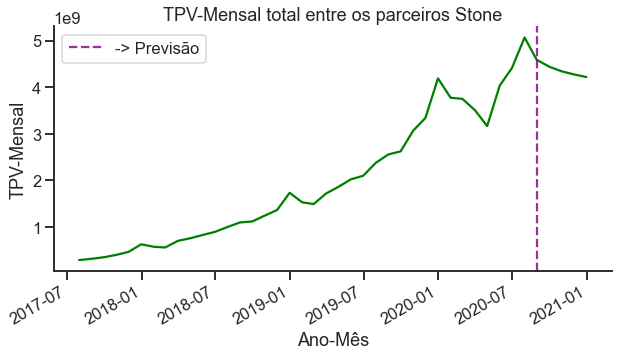

In [95]:
fig, ax = plt.subplots(figsize = (10,5))

df = df_treinado.groupby('mes_referencia')['TPV_mensal'].sum()

sns.lineplot(x = df.index, y = df, ax = ax, color = 'g')

ax.axvline(x = np.datetime64('2020-08-30'), color = 'purple', alpha = 0.8, ls = '--', label = '-> Previsão')

ax.set(title = 'TPV-Mensal total entre os parceiros Stone',
       xlabel = 'Ano-Mês',
       ylabel = 'TPV-Mensal')

plt.legend()
sns.despine()
sns.set_style('ticks')
sns.set_context('talk')
fig.autofmt_xdate()

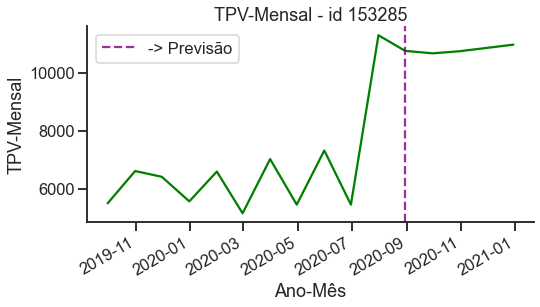

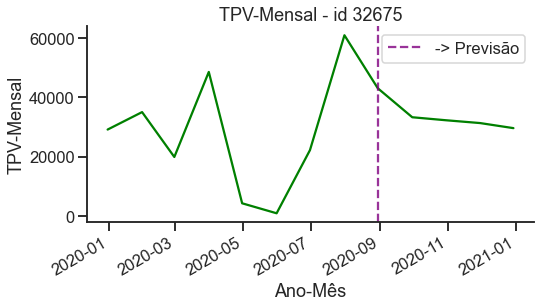

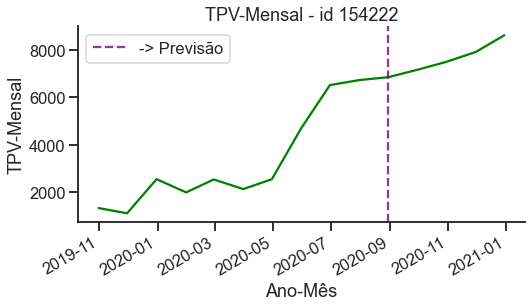

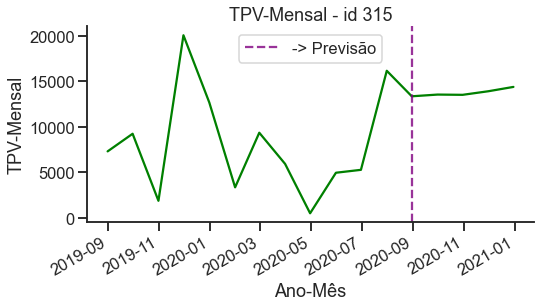

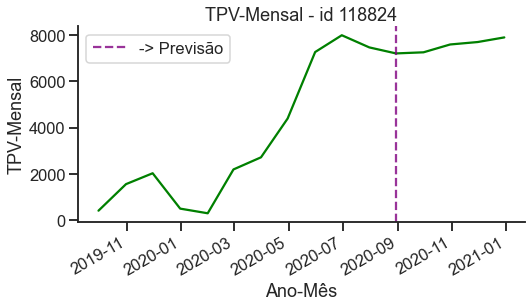

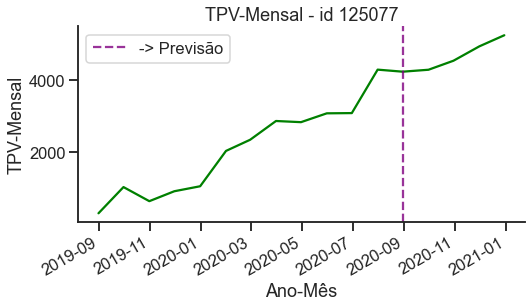

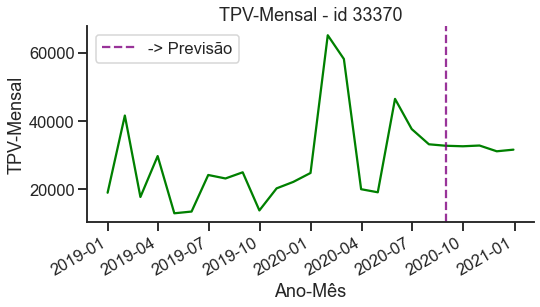

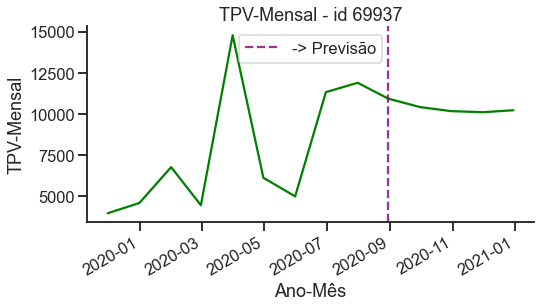

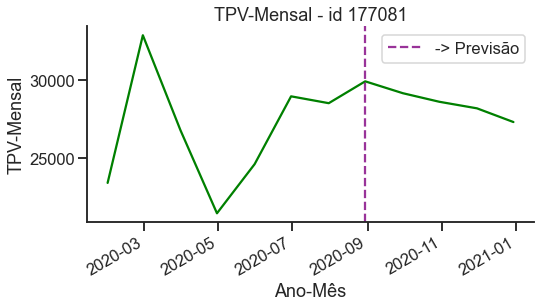

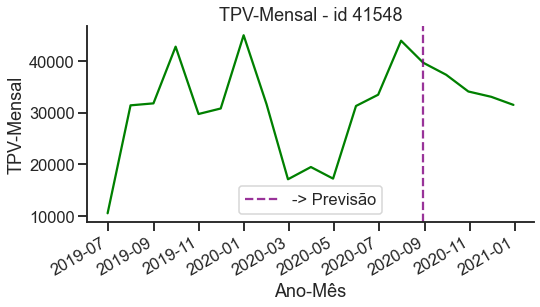

In [96]:
np.random.seed(42)
ids = np.random.choice(df_treinado.id.unique(), size = 10)

for id in ids:
    
    fig, ax = plt.subplots(figsize = (8,4))

    df = df_treinado[df_treinado.id == id][['mes_referencia', 'TPV_mensal']]

    sns.lineplot(x = 'mes_referencia', y = 'TPV_mensal', data = df, ax = ax, color = 'g')

    ax.axvline(x = np.datetime64('2020-08-30'), color = 'purple', alpha = 0.8, ls = '--', label = '-> Previsão')
    
    ax.set(title = f'TPV-Mensal - id {id}',
           xlabel = 'Ano-Mês',
           ylabel = 'TPV-Mensal')
    
    plt.legend()
    sns.despine()
    sns.set_context('talk')
    fig.autofmt_xdate()